In [ ]:
# import header files
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import glob
import os
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import time
import copy
import tqdm
import torch
import random
from PIL import Image
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader

In [ ]:
# load my google drive
def auth_gdrive():
  from google.colab import drive
  if os.path.exists('content/gdrive/My Drive'): return
  drive.mount('/content/gdrive')
def load_gdrive_dataset():
  loader_assets = 'OurALL_IDB2.zip'
  auth_gdrive()

In [ ]:
# mount my google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
load_gdrive_dataset()

Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip ALL_IDB2 dataset
!unzip "/content/gdrive/MyDrive/OurALL-IDB2.zip"

Archive:  /content/gdrive/MyDrive/OurALL-IDB2.zip
   creating: OurALL-IDB2/
   creating: OurALL-IDB2/content/
   creating: OurALL-IDB2/content/dataset/
   creating: OurALL-IDB2/content/dataset/test/
   creating: OurALL-IDB2/content/dataset/test/blast/
  inflating: OurALL-IDB2/content/dataset/test/blast/Im027_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im028_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im029_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im030_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im031_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im032_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im033_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im034_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im035_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im036_1.tif  
  inflating: OurALL-IDB2/content/dataset/test/blast/Im037_1.tif  
  inflating: OurALL-ID

In [ ]:
# Count the number of samples in the training set, validation set and test set
trainingset_healthy = os.listdir("/content/OurALL-IDB2/content/dataset/train/healthy/")
trainingset_blast = os.listdir("/content/OurALL-IDB2/content/dataset/train/blast/")
number_trainingset = len(trainingset_healthy+trainingset_blast)
print("The number of samples in the training set is:", number_trainingset)
validationset_healthy = os.listdir("/content/OurALL-IDB2/content/dataset/validation/healthy/")
validationset_blast = os.listdir("/content/OurALL-IDB2/content/dataset/validation/blast/")
number_validationset = len(validationset_healthy+validationset_blast)
print("The number of samples in the validation set is:", number_validationset)
testset_healthy = os.listdir("/content/OurALL-IDB2/content/dataset/test/healthy/")
testset_blast = os.listdir("/content/OurALL-IDB2/content/dataset/test/blast/")
number_testset = len(testset_healthy+testset_blast)
print("The number of samples in the test set is:", number_testset)

The number of samples in the training set is: 750
The number of samples in the validation set is: 100
The number of samples in the test set is: 150


In [ ]:
# define transforms
train_transforms = torchvision.transforms.Compose([torchvision.transforms.RandomRotation(30),
                                       torchvision.transforms.Resize((32, 32)),
                                       torchvision.transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# get data
train_data = torchvision.datasets.ImageFolder("/content/OurALL-IDB2/content/dataset/train/", transform=train_transforms)
train_data = torchvision.datasets.ImageFolder("/content/OurALL-IDB2/content/dataset/validation/", transform=train_transforms)
test_data = torchvision.datasets.ImageFolder("/content/OurALL-IDB2/content/dataset/test/", transform=train_transforms)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Labels:  ['healty', 'healty', 'blast', 'blast', 'blast', 'healty', 'healty', 'healty']


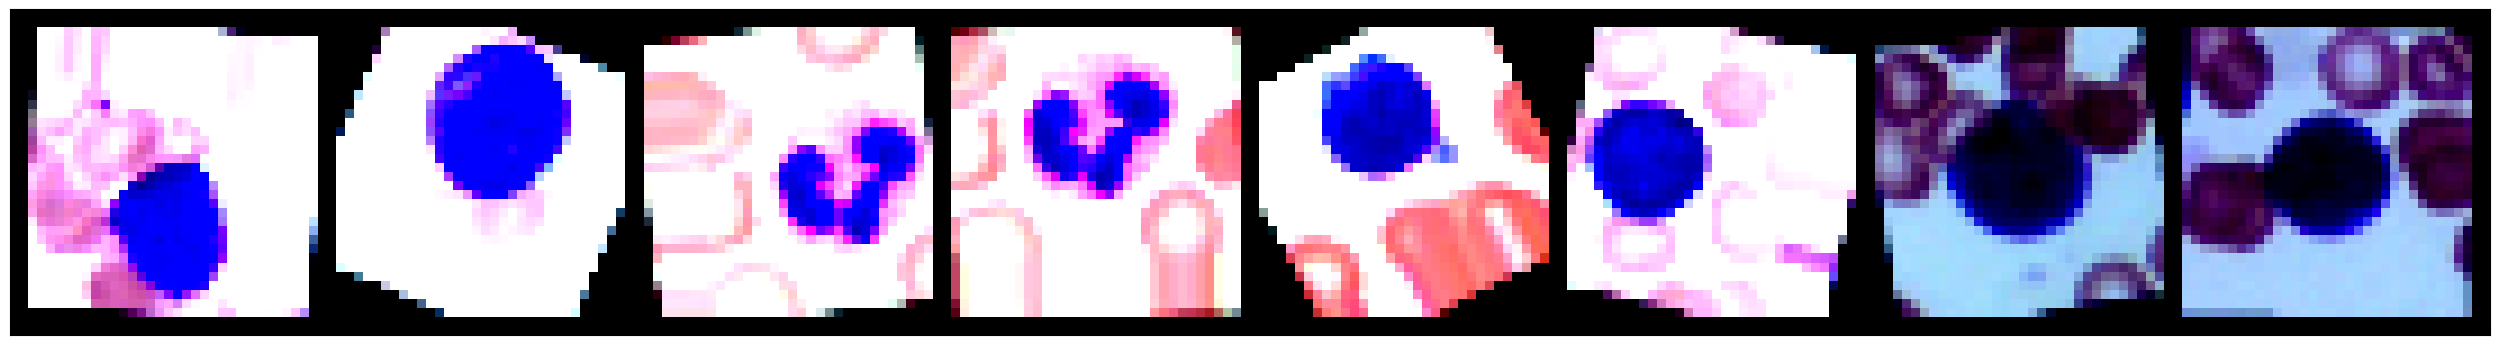

In [ ]:
# data loader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=1, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=1, pin_memory=True)
#Create a list of our detection classes
classes = ["healty", "blast"]
#plot random a batch images
from torchvision.utils import make_grid
def show_batch(dl, classes):
  for data, labels in dl:
    fig, ax = plt.subplots(figsize=(32, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(data[:32], nrow=8).squeeze().permute(1, 2, 0).clamp(0,1))
    print('Labels: ', list(map(lambda l: classes[l], labels)))
    break
show_batch(trainloader, classes)

In [ ]:
# define NPVDAB
class ChannelAttention(nn.Module):
    def __init__(self):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.avg_pool(x) + self.max_pool(x))

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(avg_out + max_out)

class NPVDAB(nn.Module):
    def __init__(self, use_skip_connection = False):
        super(NPVDAB, self).__init__()

        self.ca = ChannelAttention()
        self.sa = SpatialAttention()
        self.use_skip_connection = use_skip_connection

    def forward(self, x):

        out = x + x * self.ca(x) if self.use_skip_connection else x * self.ca(x)
        out = out + out * self.sa(out) if self.use_skip_connection else out * self.sa(out)

        return out

In [ ]:
# define the model
class MobileNetNPVDAB(nn.Module):
    def __init__(self, classes = 2):
        super(MobileNetNPVDAB, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                NPVDAB(use_skip_connection = True),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 1),
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Linear(1024, classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 32*32)
        x = self.fc(x)
        return x

In [ ]:
# print the model
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetNPVDAB()
model.to(device)

MobileNetNPVDAB(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): NPVDAB(
        (ca): ChannelAttention(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (max_pool): AdaptiveMaxPool2d(output_size=1)
          (sigmoid): Sigmoid()
        )
        (sa): SpatialAttention(
          (sigmoid): Sigmoid()
        )
      )
      (6): ReLU(inplace=True)
    )

In [ ]:
# print summary of the model
from torchvision import models
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]           2,048
       BatchNorm2d-8         [-1, 64, 256, 256]             128
 AdaptiveAvgPool2d-9             [-1, 64, 1, 1]               0
AdaptiveMaxPool2d-10             [-1, 64, 1, 1]               0
          Sigmoid-11             [-1, 64, 1, 1]               0
 ChannelAttention-12             [-1, 64, 1, 1]               0
          Sigmoid-13          [-1, 1, 256, 256]               0
 SpatialAttention-14          [-1, 1, 2

In [ ]:
 # loss function to be used
criterion = torch.nn.CrossEntropyLoss()
# optimizer to be used
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, weight_decay=5e-4)

In [ ]:
# training process
from torch.utils.tensorboard import SummaryWriter
train_losses = 0.0
train_accuracy = 0
epochs = 40
for epoch in range(epochs):  # loop over the dataset multiple times
    print('Epoch-{0}:'.format(epoch + 1, optimizer.param_groups[0]['lr']))
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda() # for using data in GPU
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs) # forward
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backward loss
        optimizer.step() # optimize gradients
        train_losses += loss.item() # save loss
        _, preds = torch.max(outputs, 1) # save prediction
        train_accuracy += torch.sum(preds == labels.data) # save train_accuracy
        if i % 1000 == 999:    # every 1000 mini-batches...
            steps = epoch * len(trainloader) + i # calculate steps
            batch = i*batch_size # calculate batch
            print("Training loss {:.5} Training Accuracy {:.5} Steps: {}".format(train_losses / batch, train_accuracy/batch, steps))
            # Save train_accuracy and loss to Tensorboard
            writer.add_scalar('Training loss by steps', train_losses / batch, steps)
            writer.add_scalar('Training accuracy by steps', train_accuracy / batch, steps)
    print("Training Accuracy: {}/{} ({:.5} %) Training Loss: {:.5}".format(train_accuracy, len(trainloader), 100. * train_accuracy / len(trainloader.dataset), train_losses / len(trainloader.dataset)))
    train_losses = 0.0
    train_accuracy = 0
print('Train is finished...')

In [ ]:
# validation process
from torch.utils.tensorboard import SummaryWriter
validation_losses = 0.0
validation_accuracy = 0
epochs = 40
for epoch in range(epochs):  # loop over the dataset multiple times
    print('Epoch-{0}:'.format(epoch + 1, optimizer.param_groups[0]['lr']))
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda() # for using data in GPU
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs) # forward
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backward loss
        optimizer.step() # optimize gradients
        validation_losses += loss.item() # save loss
        _, preds = torch.max(outputs, 1) # save prediction
        validation_accuracy += torch.sum(preds == labels.data) # save validation_accuracy
        if i % 1000 == 999:    # every 1000 mini-batches...
            steps = epoch * len(trainloader) + i # calculate steps
            batch = i*batch_size # calculate batch
            print("validation loss {:.5} validation accuracy {:.5} Steps: {}".format(validation_losses / batch, train_accuracy/batch, steps))
            # Save train_accuracy and loss to Tensorboard
            writer.add_scalar('validation loss by steps', validation_losses / batch, steps)
            writer.add_scalar('validation accuracy by steps', validation_accuracy / batch, steps)
    print("validation accuracy: {}/{} ({:.5} %) validation loss: {:.5}".format(validation_accuracy, len(validationloader), 100. * validation_accuracy / len(validationloader.dataset), validation_losses / len(validationloader.dataset)))
    validation_losses = 0.0
    validation_accuracy = 0
print('validation is finished...')

In [ ]:
# test process
from torch.utils.tensorboard import SummaryWriter
test_losses = 0.0
test_accuracy = 0
epochs = 40
for epoch in range(epochs):  # loop over the dataset multiple times
    print('Epoch-{0}:'.format(epoch + 1, optimizer.param_groups[0]['lr']))
    for i, data in enumerate(testloader, 0):
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda() # for using data in GPU
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs) # forward
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backward loss
        optimizer.step() # optimize gradients
        test_losses += loss.item() # save loss
        _, preds = torch.max(outputs, 1) # save prediction
        test_accuracy += torch.sum(preds == labels.data) # save test_accuracy
        if i % 1000 == 999:    # every 1000 mini-batches...
            steps = epoch * len(testloader) + i # calculate steps
            batch = i*batch_size # calculate batch
            print("Test loss {:.5} Test Accuracy {:.5} Steps: {}".format(test_losses / batch, test_accuracy/batch, steps))
            # Save test_accuracy and loss to Tensorboard
            writer.add_scalar('Test loss by steps', test_losses / batch, steps)
            writer.add_scalar('Test accuracy by steps', test_accuracy / batch, steps)
    print("Test Accuracy: {}/{} ({:.5} %) Test Loss: {:.5}".format(test_accuracy, len(testloader), 100. * test_accuracy / len(testloader.dataset), test_losses / len(testloader.dataset)))
    test_losses = 0.0
    test_accuracy = 0
print('Test is Finished...')

In [ ]:
# import Times New Roman font
import matplotlib.font_manager
!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plot test confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
y_pred = []
y_true = []
# iterate over test data
for inputs, labels in testloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Greys)

Original healthy Image (Im137_0):


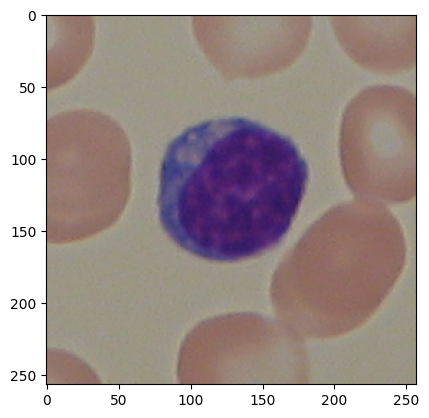

In [ ]:
# plot a healthy image from test set
import tensorflow
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
image = load_img('/content/OurALL-IDB2/content/dataset/train/healthy/Im137_0.tif')
data = img_to_array(image)
samples = np.expand_dims(data, 0)
print('Original healthy Image (Im137_0):')
plt.imshow(image)
plt.show()

In [ ]:
from torchvision import models, transforms, utils
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 27
conv_layers


In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 256, 256])
Image shape after: torch.Size([1, 3, 256, 256])


In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
# print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

27
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 256, 256])
torch.Size([1, 128, 256, 256])
torch.Size([1, 128, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 1024, 32, 32])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


In [ ]:
# plot feature maps of the healthy image
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(7, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

Original blast Image (Im002_1):


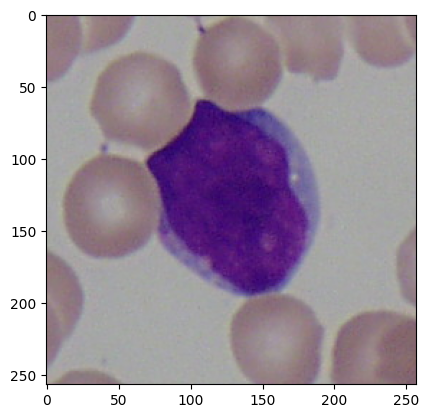

In [ ]:
# plot a blast image from test set
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
image = load_img('/content/OurALL-IDB2/content/dataset/train/blast/Im002_1.tif')
data = img_to_array(image)
samples = np.expand_dims(data, 0)
print('Original blast Image (Im002_1):')
plt.imshow(image)
plt.show()

In [ ]:
from torchvision import models, transforms, utils
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 27
conv_layers


In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 256, 256])
Image shape after: torch.Size([1, 3, 256, 256])


In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

27
torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 256, 256])
torch.Size([1, 128, 256, 256])
torch.Size([1, 128, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 1024, 32, 32])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


In [ ]:
# plot feature maps of the blast image
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(7, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)